# -*- coding: utf-8 -*-
"""
Complete stock price prediction model using multivariate features:
- Price and Volume data from yfinance.
- Technical indicators: SMA (50-day), RSI (14-day) and MACD.
- LSTM model to predict the stock's closing price.
- Evaluation using R-squared.
- Plotting of raw data and technical indicators.
"""

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import yfinance as yf
import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
from bs4 import BeautifulSoup





In [9]:

# -----------------------------
# 1. Data Download and Technical Indicators Calculation
# -----------------------------
TICKER = "META"       # Change ticker if desired
START_DATE = "2015-01-01"
END_DATE   = "2023-12-31"

# Download historical data
df = yf.download(TICKER, start=START_DATE, end=END_DATE)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].reset_index()
df = df.rename(columns={'index': 'Date'})



[*********************100%***********************]  1 of 1 completed


In [4]:



# 1. Function to fetch IPO date from Wikipedia
def get_ipo_date(ticker):
    try:
        url = f"https://en.wikipedia.org/wiki/{ticker}"
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        ipo_row = soup.find('th', string='IPO').find_next_sibling('td')
        ipo_date = datetime.strptime(ipo_row.text.strip(), '%B %d, %Y')
        return ipo_date.strftime('%Y-%m-%d')
    except:
        print(f"Could not fetch IPO date for {ticker}. Using Yahoo Finance's max history.")
        return None

# 2. Get dynamic IPO date and historical data
ticker = "AAPL"  # Replace with your stock symbol
ipo_date = get_ipo_date(ticker)
stock = yf.Ticker(ticker)

if ipo_date:
    df = stock.history(start=ipo_date)  # From actual IPO date
else:
    df = stock.history(period="max")  # Fallback to Yahoo's max data

# 3. Create the chart
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05)

# Candlestick
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    increasing_fillcolor='#2ecc71',  # Modern green
    decreasing_fillcolor='#e74c3c',  # Modern red
    line=dict(width=1),
    name='Price'
), row=1, col=1)

# Volume
fig.add_trace(go.Bar(
    x=df.index,
    y=df['Volume'],
    marker_color=np.where(df['Close'] >= df['Open'], '#2ecc71', '#e74c3c'),
    opacity=0.7,
    name='Volume'
), row=2, col=1)

# Layout
fig.update_layout(
    title=f'{ticker} Complete History (IPO to Present)',
    xaxis=dict(
        rangebreaks=[dict(bounds=["sat", "mon"])],
        type='date',
        rangeslider=dict(visible=False)
    ),
    template='plotly_white',  # Professional dark theme
    hovermode='x unified'
)

fig.show()

Could not fetch IPO date for AAPL. Using Yahoo Finance's max history.


In [1]:
# Calculate SMA_50 (50-day simple moving average)
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# print(df['SMA_50'])


NameError: name 'df' is not defined

In [12]:
# Calculate RSI (14-day)
def calculate_RSI(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

df['RSI'] = calculate_RSI(df['Close'], period=14)

In [13]:

# Calculate MACD
ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()  # optional signal line

# Drop NaN values created by indicator calculations
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

<Figure size 1400x1000 with 0 Axes>

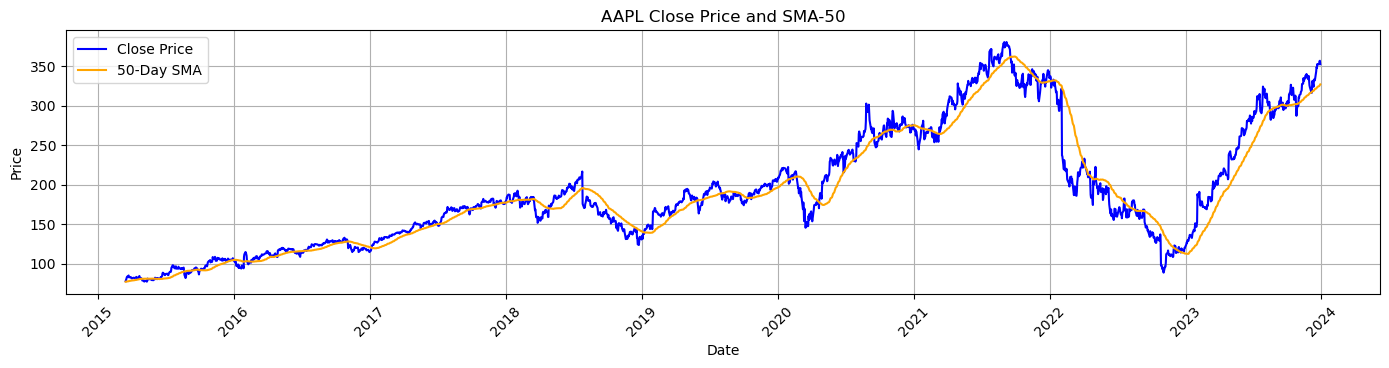

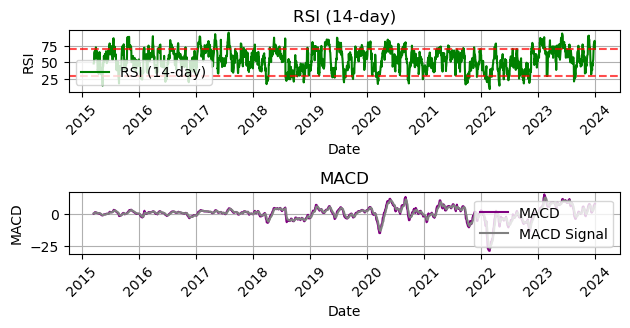

In [14]:
# -----------------------------
# 2. Plot Raw Data and Technical Indicators
# -----------------------------
plt.figure(figsize=(14, 10))

# # Plot Close Price and SMA_50
# plt.subplot(3, 1, 1)
# plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
# plt.plot(df['Date'], df['SMA_50'], label='50-Day SMA', color='orange')
# plt.title(f"{TICKER} Close Price and SMA-50")
# plt.xlabel("Date")
# plt.ylabel("Price")
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)


# Now plot Close + SMA
plt.figure(figsize=(14, 10))
plt.subplot(3, 1, 1)
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.plot(df['Date'], df['SMA_50'], label='50-Day SMA', color='orange')
plt.title(f"{ticker} Close Price and SMA-50")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot RSI
plt.subplot(3, 1, 2)
plt.plot(df['Date'], df['RSI'], label='RSI (14-day)', color='green')
plt.axhline(70, linestyle='--', color='red', alpha=0.7)
plt.axhline(30, linestyle='--', color='red', alpha=0.7)
plt.title("RSI (14-day)")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)





# Plot MACD
plt.subplot(3, 1, 3)
plt.plot(df['Date'], df['MACD'], label='MACD', color='purple')
plt.plot(df['Date'], df['MACD_signal'], label='MACD Signal', color='gray')
plt.title("MACD")
plt.xlabel("Date")
plt.ylabel("MACD")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [17]:

# -----------------------------
# 3. Data Preparation for LSTM
# -----------------------------
# Use the following features: Close, Volume, SMA_50, RSI, MACD
features = ['Close', 'Volume', 'SMA_50', 'RSI', 'MACD']
data = df[features].values

# Scale the features to range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_sequences(dataset, window_size):
    X, y = [], []
    for i in range(window_size, len(dataset)):
        X.append(dataset[i-window_size:i])
        y.append(dataset[i, 0])  # Predicting Close price (first column)
    return np.array(X), np.array(y)

WINDOW_SIZE = 60
X, y = create_sequences(scaled_data, WINDOW_SIZE)

# Split into training and testing sets (80/20 split)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test   = X[train_size:], y[train_size:]
dates_test = df['Date'].iloc[WINDOW_SIZE + train_size:].values

In [18]:

# -----------------------------
# 4. Build and Train the LSTM Model
# -----------------------------
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_split=0.1, callbacks=[early_stop], verbose=1)


c:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - loss: 0.0601 - root_mean_squared_error: 0.2349 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0859
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 0.0033 - root_mean_squared_error: 0.0571 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0811
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0029 - root_mean_squared_error: 0.0542 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0684
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0029 - root_mean_squared_error: 0.0540 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1044
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0030 - root_mean_squared_error: 0.0541 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0608
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0022 - root_mean_squared_error: 0.0469 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0756
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - los

In [19]:

# -----------------------------
# 5. Make Predictions and Evaluate the Model
# -----------------------------
# Predict on test set
pred_scaled = model.predict(X_test)

# To inverse transform the Close price predictions,
# we create an array with the prediction in first column and zeros for the other features,
# then apply scaler.inverse_transform, and take the first column.
dummy = np.zeros((len(pred_scaled), len(features)))
dummy[:, 0] = pred_scaled[:, 0]
predicted = scaler.inverse_transform(dummy)[:, 0]

# Do the same for true values
dummy_true = np.zeros((len(y_test), len(features)))
dummy_true[:, 0] = y_test
actual = scaler.inverse_transform(dummy_true)[:, 0]

# Calculate R-squared
r_squared = r2_score(actual, predicted)
print(f"R-squared: {r_squared:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step
R-squared: 0.9583


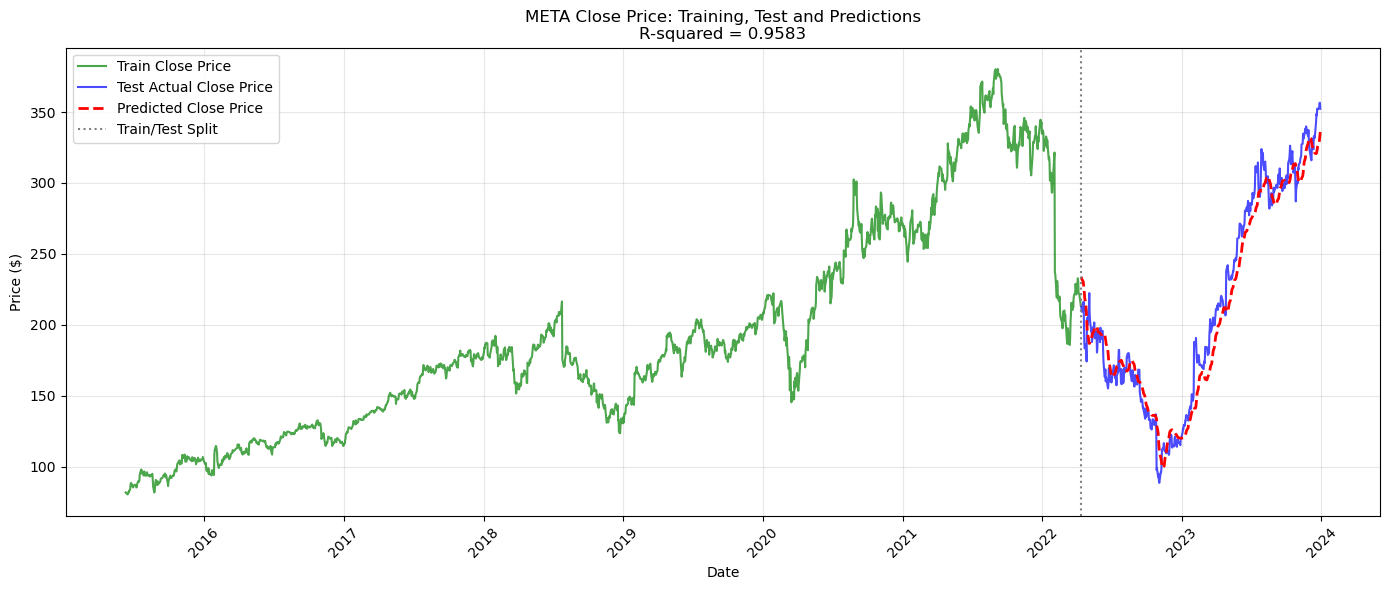

In [20]:
# -----------------------------
# 6. Plot Actual vs Predicted Close Prices (with Training Data)
# -----------------------------

# Get dates for training data (skip the first WINDOW_SIZE points used for sequences)
dates_train = df['Date'].iloc[WINDOW_SIZE:WINDOW_SIZE + train_size].values

# Get actual training values (already scaled and inverse transformed)
dummy_train = np.zeros((len(y_train), len(features)))
dummy_train[:, 0] = y_train
train_actual = scaler.inverse_transform(dummy_train)[:, 0]

plt.figure(figsize=(14, 6))

# Plot training data
plt.plot(dates_train, train_actual, label='Train Close Price', color='green', alpha=0.7)

# Plot actual test data
plt.plot(dates_test, actual, label='Test Actual Close Price', color='blue', alpha=0.7)

# Plot predicted data
plt.plot(dates_test, predicted, label='Predicted Close Price', color='red', linestyle='--', linewidth=2)

# Add vertical line to show train/test split
split_date = dates_train[-1]
plt.axvline(x=split_date, color='gray', linestyle=':', label='Train/Test Split')

# Labels and formatting
plt.title(f"{TICKER} Close Price: Training, Test and Predictions\nR-squared = {r_squared:.4f}")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

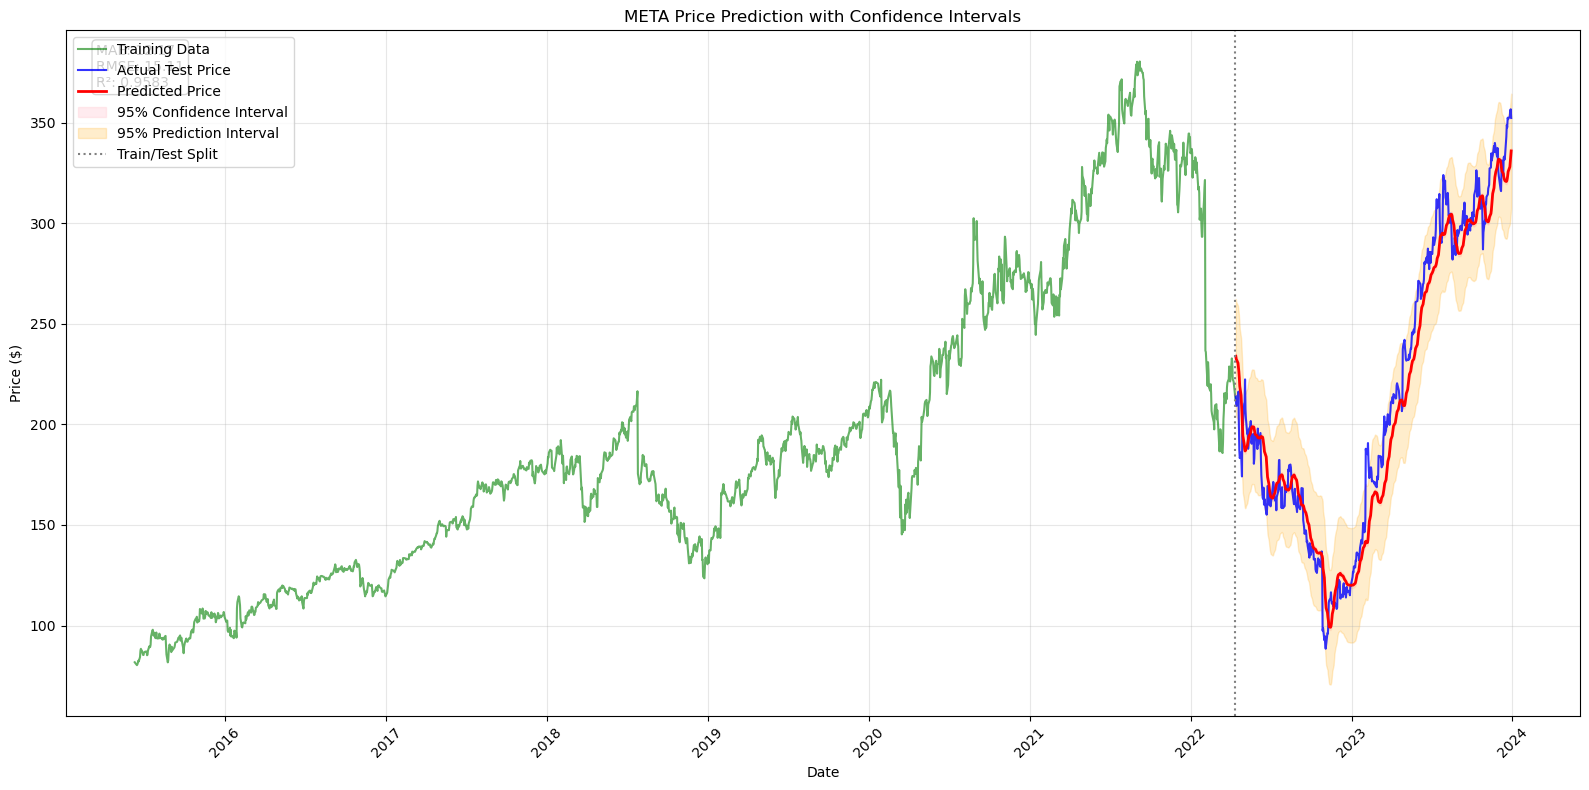

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -----------------------------
# Calculate Error Metrics
# -----------------------------
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))

# Calculate prediction residuals
residuals = actual - predicted
std_residuals = np.std(residuals)

# Create confidence and prediction intervals
confidence_interval = 1.96 * std_residuals / np.sqrt(len(actual))
prediction_interval = 1.96 * std_residuals

lower_conf = predicted - confidence_interval
upper_conf = predicted + confidence_interval
lower_pred = predicted - prediction_interval
upper_pred = predicted + prediction_interval

# -----------------------------
# Enhanced Visualization
# -----------------------------
plt.figure(figsize=(16, 8))

# Plot training data
plt.plot(dates_train, train_actual, label='Training Data', color='green', alpha=0.6)

# Plot test data
plt.plot(dates_test, actual, label='Actual Test Price', color='blue', alpha=0.8)

# Plot predictions with intervals
plt.plot(dates_test, predicted, label='Predicted Price', color='red', linewidth=2)
plt.fill_between(dates_test, lower_conf, upper_conf, color='pink', alpha=0.3, label='95% Confidence Interval')
plt.fill_between(dates_test, lower_pred, upper_pred, color='orange', alpha=0.2, label='95% Prediction Interval')

# Add error metrics to plot
textstr = '\n'.join((
    f'MAE: {mae:.2f}',
    f'RMSE: {rmse:.2f}',
    f'R²: {r_squared:.4f}'))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes,
        verticalalignment='top', bbox=props)

# Add train/test split line
split_date = dates_train[-1]
plt.axvline(x=split_date, color='gray', linestyle=':', label='Train/Test Split')

# Formatting
plt.title(f"{TICKER} Price Prediction with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate error metrics
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
residuals = actual - predicted
std_residuals = np.std(residuals)
avg_price = np.mean(actual)

# Calculate intervals
confidence_interval = 1.96 * std_residuals / np.sqrt(len(actual))
prediction_interval = 1.96 * std_residuals

# Generate confidence report
confidence_report = f"""
**Prediction Confidence Analysis**

1. Error Metrics:
   - Mean Absolute Error (MAE): ${mae:.2f} ({100*mae/avg_price:.1f}% of average price)
   - Root Mean Squared Error (RMSE): ${rmse:.2f}
   - Standard Deviation of Errors: ${std_residuals:.2f}

2. Prediction Intervals (95% confidence):
   - Confidence Interval (mean prediction): ±${confidence_interval:.2f}
   - Prediction Interval (individual forecasts): ±${prediction_interval:.2f}

3. Model Accuracy:
   - R² Score: {r_squared:.4f}
   - Typical Error Range: ±${mae:.2f} to ±${rmse:.2f}

**Interpretation Example**:
For a predicted closing price of $100 tomorrow:
- 95% probability the actual price will be between ${100-prediction_interval:.2f} and ${100+prediction_interval:.2f}
- The model explains {100*r_squared:.1f}% of price variability
"""

print(confidence_report)

# For next day's specific prediction (example):
next_day_pred = 150.00  # Replace with your model's actual prediction
print(f"\nExample for ${next_day_pred:.2f} prediction:")
print(f"95% confidence range: ${next_day_pred-prediction_interval:.2f} to ${next_day_pred+prediction_interval:.2f}")
print(f"Expected accuracy: ±{100*mae/avg_price:.1f}% (${mae:.2f})")


**Prediction Confidence Analysis**

1. Error Metrics:
   - Mean Absolute Error (MAE): $12.17 (5.6% of average price)
   - Root Mean Squared Error (RMSE): $15.11
   - Standard Deviation of Errors: $14.52

2. Prediction Intervals (95% confidence):
   - Confidence Interval (mean prediction): ±$1.37
   - Prediction Interval (individual forecasts): ±$28.45

3. Model Accuracy:
   - R² Score: 0.9583
   - Typical Error Range: ±$12.17 to ±$15.11

**Interpretation Example**:
For a predicted closing price of $100 tomorrow:
- 95% probability the actual price will be between $71.55 and $128.45
- The model explains 95.8% of price variability


Example for $150.00 prediction:
95% confidence range: $121.55 to $178.45
Expected accuracy: ±5.6% ($12.17)


In [24]:
# -----------------------------
# 7. Save the Model
# -----------------------------
model.save("multivariate_lstm_model.h5")

In [25]:
# Save the scaler object for use in Flask API
import joblib
joblib.dump(scaler, 'scaler.save')
print("Model and scaler saved successfully.")

Model and scaler saved successfully.
